In [2]:
import kagglehub
import os
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("raghadalharbi/breast-cancer-gene-expression-profiles-metabric")

print("Path to dataset files:", path)
df = pd.read_csv(os.path.join(path, "METABRIC_RNA_Mutation.csv"))

/mnt/d/Forschung/Breast-Cancer-Treatment-Prediction/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/kesslermatics/.cache/kagglehub/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric/versions/1


/tmp/ipykernel_32394/2461765115.py:9: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(path, "METABRIC_RNA_Mutation.csv"))


/tmp/ipykernel_32394/2753520122.py:14: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(path, "METABRIC_RNA_Mutation.csv"))


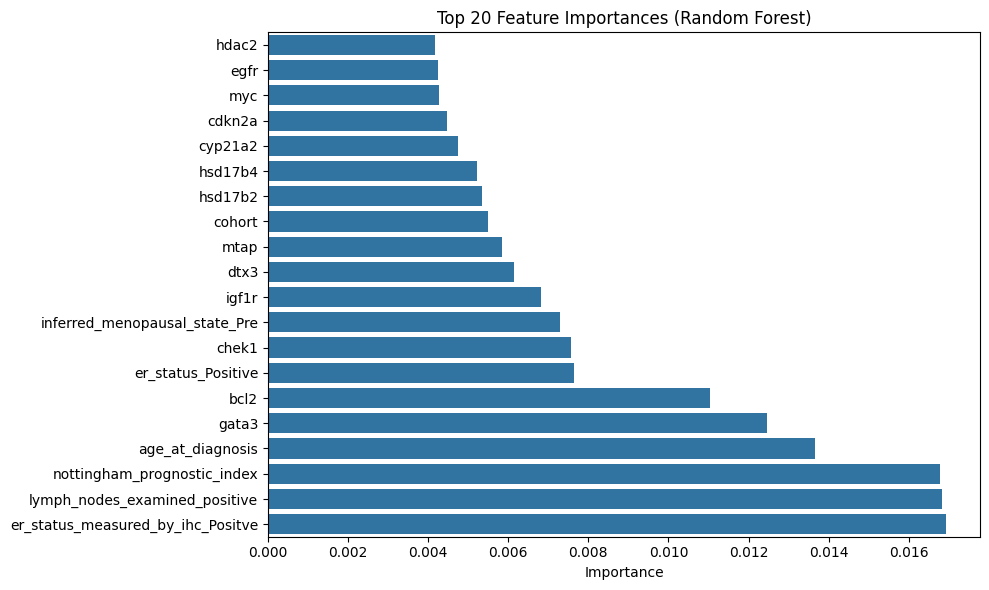

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the data (du hast das schon getan)
df = pd.read_csv(os.path.join(path, "METABRIC_RNA_Mutation.csv"))

# Drop rows with missing target
df = df.dropna(subset=["chemotherapy"])

# Drop ID and known outcome variables
drop_cols = [
    "patient_id"
]
X = df.drop(columns=drop_cols + ["chemotherapy"], errors="ignore")
y = df["chemotherapy"].astype(int)

# Keep only useful columns
X = X.loc[:, X.nunique() > 1]  # drop constant cols
X = X.dropna(axis=1, thresh=int(0.8 * len(X)))  # drop cols with >20% missing
combined = pd.concat([X, y], axis=1).dropna()
X = combined.drop(columns=["chemotherapy"])
y = combined["chemotherapy"]

# Split columns by type
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "bool", "category"]).columns.tolist()
X[categorical_cols] = X[categorical_cols].astype(str)

# Preprocessing
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_cols)
])

# Pipeline with Random Forest
pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Fit model
pipeline.fit(X_train, y_train)

# Get feature names
encoded_cat_names = pipeline.named_steps["preprocess"].named_transformers_["cat"].get_feature_names_out(categorical_cols)
feature_names = numeric_cols + list(encoded_cat_names)

# Get importances
importances = pipeline.named_steps["clf"].feature_importances_
indices = np.argsort(importances)[::-1][:20]

# Plot
os.makedirs("../outputs/figures", exist_ok=True)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices][::-1], y=np.array(feature_names)[indices][::-1])
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig("../outputs/figures/feature_importance_random_forest.png")
plt.show()
